(4000, 6000)


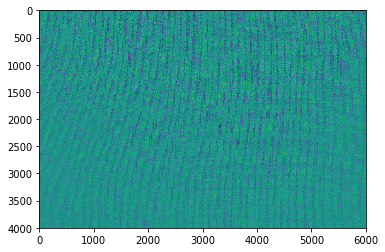

(1, 4000, 6000, 1)


In [0]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import backend as K
from keras.layers import Layer, Input, Lambda


img = cv2.imread('preptest11.jpg', 0)
print(img.shape)

#plt.imshow(img,cmap='gray')
plt.imshow(img)
plt.show()

# (y,x) = (4000, 6000)

img = tf.reshape(img, [1,img.shape[0],img.shape[1],1])
print(img.shape)

In [0]:
%%time

"""
        input_shape_inbuild:  (None, 6000, 4000, 1)
#         ---LAYER---
#         Input Size: (None, 6000, 4000, 1)
#         Patch Size: (x,y) = 48, 32
#         Aspect ratio: (3, 2)
#         ---LAYER---
#         Output shape:  <unknown>
#         Result shape:  (1, 125, 125, 1536) 



Input_shape (x,y,1)
(6000, 4000, 1)

---layer---
Output shape (x,y,(imDim/patchDim))

(16 * 3 , 16 * 2 , (6000/48) * (4000/32))

(48, 32, 125 * 125)

(48, 32, 15625) # total patch count is 15625 
                # patch dim is 48x32
                
***tensorflow takes images as (y, x)
so a 6000x4000 im is given as tf.func(4000, 6000)

"""

class create_patches(Layer):
    
    def __init__(self, patchMultiplier):
        super(create_patches, self).__init__()
        self.patchMultiplier = patchMultiplier

    
    def build(self, input_shape):
        
        print('input_shape_inbuild: ', input_shape)
        def aspect_ratio(width, height):
            
            def gcd(x, y):
                while y != 0:
                    (x, y) = (y, x % y)
                return x
            
            r = gcd(width, height)
            x = int(width/r)
            y = int(height/r)
            return x, y
        
        self.aspect_ratio = aspect_ratio(input_shape[1], input_shape[2])
        self.patchSize_x = self.aspect_ratio[0] * self.patchMultiplier
        self.patchSize_y = self.aspect_ratio[1] * self.patchMultiplier


    def call(self, inputs):
        
        print('---LAYER---')
        
        print('Input Size:', inputs._keras_shape)
        
        print('Patch Size: (x,y) = {}, {}'.format(self.patchSize_x, self.patchSize_y))
        
        print('Aspect ratio: {}'.format(self.aspect_ratio))
        
        print('---LAYER---')
        out = tf.extract_image_patches(images=inputs, 
                                        ksizes=[1, self.patchSize_y, self.patchSize_x, 1], 
                                        strides=[1, self.patchSize_y, self.patchSize_x, 1], 
                                        rates=[1, 1, 1, 1], 
                                        padding='VALID')

        
        return out
    
    def compute_output_shape(self, input_shape):

        """
        ksize_cols = patchSize_x
        ksize_rows = patchSize_y
        """

        #output shape=[batch, out_rows, out_cols, ksize_rows * ksize_cols * depth]

        """
        shape = (self.patchSize_x, self.patchSize_y, 
                (input_shape[1]/self.patchSize_x) * (input_shape[2]/self.patchSize_y))
        """

        shape =(input_shape[0],
                input_shape[1]/self.patchSize_x, # patch row count
                input_shape[2]/self.patchSize_y, # patch col count
                self.patchSize_x * self.patchSize_y) # patch pixel count


        return shape

    
"""
input_shape_1 = Input(shape=(28, 28, 1))
print(input_shape_1._keras_shape)

x1 = create_patches()(input_shape_1)
print(x1._keras_shape)
"""

"""

if __name__ == "__main__":

    input_shape_1 = Input(shape=(6000, 4000, 1))
    
    x1 = create_patches()(input_shape_1)
    print('Output shape: ', x1.shape)

    # build the model
    f = K.function([input_shape_1], [x1])

    # eval the model on input data
    import numpy as np
    result = f([np.random.randint(256, size=(1,6000,4000,1))])
   
    #print(result)
    result = np.array(result)
    
    #[batch, out_rows, out_cols, ksize_rows * ksize_cols * depth]
    #Result shape:  (1, 1, 125, 125, 1536) 
    print('Result shape: ', result.shape, '\n\n')
    #print(result[:, :, :, 0].shape)

"""

CPU times: user 50 µs, sys: 0 ns, total: 50 µs
Wall time: 53.6 µs


In [0]:
%%time
input_shape_1 = Input(shape=(6000, 4000, 1))

x1 = create_patches(64)(input_shape_1)
print('Output shape: ', x1.shape)

# build the model
f = K.function([input_shape_1], [x1])

# Eval the model on input data

import numpy as np
#result = f([np.random.randint(256, size=(1,4000,6000,1))])
result = f([img])


#print(result)
result = np.array(result)

# [batch, out_rows, out_cols, ksize_rows * ksize_cols * depth]
# Result shape:  (1, 1, 125, 125, 1536) 
print('Result shape: ', result.shape, '\n\n')

#print(result[:, :, :, 0].shape)

input_shape_inbuild:  (None, 6000, 4000, 1)
---LAYER---
Input Size: (None, 6000, 4000, 1)
Patch Size: (x,y) = 192, 128
Aspect ratio: (3, 2)
---LAYER---
Output shape:  (?, 46, 20, 24576)
Result shape:  (1, 1, 31, 31, 24576) 


CPU times: user 791 ms, sys: 19 ms, total: 810 ms
Wall time: 727 ms


(128, 192)


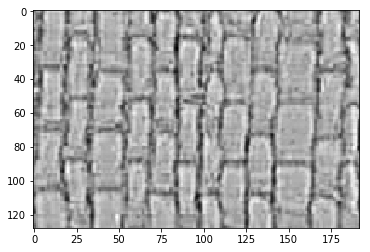

In [0]:
patch1 = result[0, 0, 15, 16, :]
sess = tf.InteractiveSession()

# define reshape matrix as (y, x)
patch1 = tf.reshape(patch1, [128,192])

print(patch1.shape)

import matplotlib.pyplot as plt

plt.imshow(sess.run(patch1), cmap='gray')
plt.show()
sess.close()